In [1]:
import numpy as np
import pandas as pd
import math
from itertools import combinations
from datetime import datetime, timedelta

In [2]:
student_counts = pd.read_csv("Data/student_counts.csv")
pair_counts = pd.read_csv("Data/module_pairs.csv")
assignments = pd.read_csv("Data/Assignments.csv")

In [3]:
instructors = pd.read_csv("Data/instructors.csv")
instructors = instructors.drop(['Days and Times'], axis = 1)
instructors = instructors.drop_duplicates()

In [4]:
assignments["Start Date"] = pd.to_datetime(assignments["Start Date"])
assignments["Due Date"] = pd.to_datetime(assignments["Due Date"])
assignments = assignments.sort_values(by=["Due Date"], na_position="last")

## Stress Score Formula (for Tuning)

- Stress Score calculation = g(weightage) + weight(level) + weight(i_or_g) + weight(type) + weight(gap)
- g is a sigmoid-like function
- then standardize it to range 0 to 10

In [5]:
# how stressful each level within the factors are
weights = {
    "level": {
        "level_1k": 0.4,
        "level_2k": 0.8,
        "level_3k": 1.2,
        "level_4k": 1.6
    },
    "i_or_g": {
        "I": 0.3,
        "G": 0.4,
        "I&G": 0.3
    },
    "type": {
        "Presentation": 0.6,
        "Project": 0.8,
        "Participation": 0.2,
        "Quiz": 0.2,
        "Assignment": 0.5,
        "Exam": 1
    },
    "gap": {
        "One Week": 0.8,
        "Two Weeks": 0.6,
        "More Than Two Weeks": 0.4,
        "Others": 0.4 # assume weight to be 0.15 if gap is not known eg. start date is NA
    }
}

## Individual Stress Score Calculation (Per Assignment)

### Assumptions & Helper Functions

In [6]:
# max_weightage = by_date["Weightage"].max()
# max weightage is 70 based on the data
# we will assume that weightage for any graded components will not exceed 70% based on department's guidelines

max_weightage = 70

# max_stress is assuming that this is the maximum possible stress for a student,so we use the highest weights for each factor
# Stress Score calculation = g(weightage) + weight(level) + weight(i_or_g) + weight(type) + weight(gap)
max_stress = 2/(1+np.exp(-0.05*max_weightage+2)) + 1.6 + 0.4 + 1 + 0.8

def normalized_score(score):
    return (score)/(max_stress)*10

In [7]:
def get_gap(due_date, start_date):
    if pd.isnull(start_date):
        return "Others"
    else:
        gap = (due_date - start_date).days
        if gap <= 7:
            return "One Week"
        elif gap <= 14:
            return "Two Weeks"
        else:
            return "More Than Two Weeks"

### Single function that takes in assignment details, outputs a stress score

In [8]:
def indiv_score(weightage, assignment_type, i_g, level, start_date=None, due_date=None):
    gap = get_gap(due_date, start_date)
    stress_score = 2/(1+np.exp(-0.05*weightage+2)) + weights['type'][assignment_type] + weights['i_or_g'][i_g] + weights['level'][level] + weights['gap'][gap]
    normalized_stress = normalized_score(stress_score)
    return normalized_stress

In [9]:
example2 = indiv_score(7.5, "Assignment", "I", "level_3k", None, None)
example2

5.021082126175125

### Single function that takes in a df, outputs a df with stress score column

In [10]:
def indiv_score_df(df):
    for i in range(0, len(df)):
        weightage = df.loc[i,"Weightage"]
        assignment_type = df.loc[i,"Type"]
        i_g = df.loc[i,"Group or Individual"]
        level = df.loc[i,"Level"]
        start_date = df.loc[i,"Start Date"]
        due_date = df.loc[i,"Due Date"]
        
        stress_score = indiv_score(weightage, assignment_type, i_g, level, start_date, due_date)
        df.loc[i, "Stress"] = stress_score
    return df

In [11]:
indiv_scores = indiv_score_df(assignments)
indiv_scores

,Module Code,Semester,Name,Weightage,Type,Group or Individual,Start Date,Due Date,Level,Stress
2,DSA1101,2010,Finals,50.0,Exam,I,NaT,2020-11-30,level_1k,6.154235
4,DSA2101,2020,Quiz 1,5.0,Quiz,I,2021-01-12,2021-01-19,level_2k,4.408517
5,DSA2101,2020,Assignment 1,2.5,Assignment,I,2021-01-19,2021-01-26,level_2k,4.904978
6,DSA2101,2020,Assignment 2,2.5,Assignment,I,2021-02-09,2021-02-16,level_2k,4.904978
9,DSA2101,2020,Take-Home Midterms,30.0,Assignment,I,2021-03-02,2021-03-06,level_2k,5.804958
...,...,...,...,...,...,...,...,...,...,...
88,ST4253,2210,Participation,10.0,Participation,I,NaT,NaT,level_4k,5.270971
89,ST4253,2210,Tutorial Presentation,10.0,Presentation,I,NaT,NaT,level_4k,6.006921
101,ST4248,2220,Presentation,10.0,Presentation,G,NaT,NaT,level_4k,6.190909
103,ST3247,2220,Tutorial Attendance,10.0,Participation,I,NaT,NaT,level_3k,4.535020


## Stress Score Distribution

In [12]:
indiv_scores.Stress.describe()

count    109.000000
mean       5.567922
std        1.511263
min        3.063119
25%        4.351033
50%        5.021082
75%        6.516183
max        9.497655
Name: Stress, dtype: float64

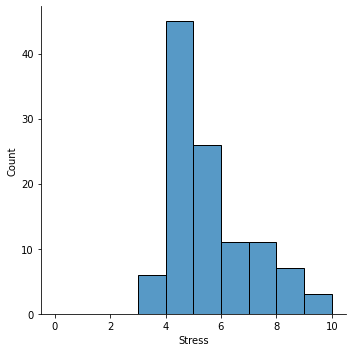

In [13]:
import seaborn as sns
sns.displot(indiv_scores, x="Stress", bins=[0,1,2,3,4,5,6,7,8,9,10])

In [14]:
# mean stress score for each category
indiv_scores.groupby(['Level', 'Type', 'Weightage']).agg({'Stress': np.mean}).stack().unstack(level=0)

Level                           level_1k  level_2k  level_3k  level_4k
Type          Weightage                                               
Assignment    2.0       Stress       NaN  4.158519       NaN       NaN
              2.5       Stress       NaN  4.537003  4.904978       NaN
              4.0       Stress       NaN  4.201729       NaN       NaN
              5.0       Stress       NaN       NaN  4.960479  5.733227
              7.5       Stress       NaN       NaN  5.021082       NaN
              10.0      Stress  3.615082  4.351033       NaN  5.822933
              15.0      Stress       NaN       NaN       NaN  5.971134
              30.0      Stress       NaN  5.804958       NaN       NaN
              40.0      Stress       NaN       NaN       NaN  7.727479
Exam          20.0      Stress       NaN  6.325278  7.061228  7.797179
              25.0      Stress       NaN  6.516183       NaN       NaN
              30.0      Stress       NaN       NaN       NaN  7.460847
              40.0      Stress  5.703616  7.175516  7.911467  8.647417
              50.0      Stress  6.154235       NaN  8.362087  9.098037
              55.0      Stress       NaN  7.834849       NaN  9.306750
              60.0      Stress       NaN  8.025755  8.823034  9.497655
              70.0      Stress       NaN  8.344112       NaN       NaN
Participation 2.0       Stress       NaN  3.606556       NaN       NaN
              5.0       Stress       NaN  3.672566       NaN       NaN
              10.0      Stress       NaN       NaN  4.535020  5.270971
Presentation  3.0       Stress       NaN  4.363718       NaN       NaN
              10.0      Stress       NaN       NaN  5.454958  6.098915
Project       10.0      Stress       NaN       NaN       NaN  6.558884
              15.0      Stress       NaN  5.235184  5.787146       NaN
              20.0      Stress       NaN       NaN       NaN  6.877241
              25.0      Stress       NaN       NaN       NaN  6.884158
              30.0      Stress       NaN       NaN  6.540909       NaN
Quiz          3.0       Stress       NaN  3.627768       NaN       NaN
              5.0       Stress       NaN  4.040541  4.776492  5.144467
              10.0      Stress  3.063119       NaN  5.270971       NaN
              30.0      Stress       NaN  4.517045       NaN       NaN

## Examine by Score Range

### <50% Percentile

In [15]:
indiv_scores[indiv_scores['Stress']<indiv_scores.Stress.quantile(0.5)].groupby(['Level', 'Type', 'Weightage']).agg({'Stress': np.mean}).stack().unstack(level=0)

Level                           level_1k  level_2k  level_3k
Type          Weightage                                     
Assignment    2.0       Stress       NaN  4.158519       NaN
              2.5       Stress       NaN  4.537003  4.904978
              4.0       Stress       NaN  4.201729       NaN
              5.0       Stress       NaN       NaN  4.960479
              10.0      Stress  3.615082  4.351033       NaN
Participation 2.0       Stress       NaN  3.606556       NaN
              5.0       Stress       NaN  3.672566       NaN
              10.0      Stress       NaN       NaN  4.535020
Presentation  3.0       Stress       NaN  4.363718       NaN
Quiz          3.0       Stress       NaN  3.627768       NaN
              5.0       Stress       NaN  4.040541  4.408517
              10.0      Stress  3.063119       NaN       NaN
              30.0      Stress       NaN  4.517045       NaN

### > 50% percentile

In [16]:
indiv_scores[indiv_scores['Stress']>indiv_scores.Stress.quantile(0.5)].groupby(['Level', 'Type', 'Weightage']).agg({'Stress': np.mean}).stack().unstack(level=0)

Level                           level_1k  level_2k  level_3k  level_4k
Type          Weightage                                               
Assignment    5.0       Stress       NaN       NaN       NaN  5.733227
              10.0      Stress       NaN       NaN       NaN  5.822933
              15.0      Stress       NaN       NaN       NaN  5.971134
              30.0      Stress       NaN  5.804958       NaN       NaN
              40.0      Stress       NaN       NaN       NaN  7.727479
Exam          20.0      Stress       NaN  6.325278  7.061228  7.797179
              25.0      Stress       NaN  6.516183       NaN       NaN
              30.0      Stress       NaN       NaN       NaN  7.460847
              40.0      Stress  5.703616  7.175516  7.911467  8.647417
              50.0      Stress  6.154235       NaN  8.362087  9.098037
              55.0      Stress       NaN  7.834849       NaN  9.306750
              60.0      Stress       NaN  8.025755  8.823034  9.497655
              70.0      Stress       NaN  8.344112       NaN       NaN
Participation 10.0      Stress       NaN       NaN       NaN  5.270971
Presentation  10.0      Stress       NaN       NaN  5.454958  6.098915
Project       10.0      Stress       NaN       NaN       NaN  6.558884
              15.0      Stress       NaN  5.235184  5.787146       NaN
              20.0      Stress       NaN       NaN       NaN  6.877241
              25.0      Stress       NaN       NaN       NaN  6.884158
              30.0      Stress       NaN       NaN  6.540909       NaN
Quiz          5.0       Stress       NaN       NaN  5.144467  5.144467
              10.0      Stress       NaN       NaN  5.270971       NaN

### stress score between 7 and 8

In [17]:
indiv_scores[(indiv_scores['Stress']>7) & (indiv_scores['Stress']<8)].sort_values(by=['Module Code', 'Semester'])

,Module Code,Semester,Name,Weightage,Type,Group or Individual,Start Date,Due Date,Level,Stress
11,DSA2101,2020,Finals,40.0,Exam,I,2021-04-26,2021-04-26,level_2k,7.175516
25,DSA2101,2110,Finals,40.0,Exam,I,2021-11-30,2021-11-30,level_2k,7.175516
32,DSA2102,2110,Finals,55.0,Exam,I,2021-12-02,2021-12-02,level_2k,7.834849
40,DSA2102,2120,Finals,55.0,Exam,I,2022-04-25,2022-04-25,level_2k,7.834849
53,DSA3102,2210,Midterm,20.0,Exam,I,2022-09-29,2022-09-29,level_3k,7.061228
56,DSA4211,2210,Midterm,20.0,Exam,I,2022-09-28,2022-09-28,level_4k,7.797179
59,DSA4212,2220,Midterm,30.0,Exam,I,NaT,NaT,level_4k,7.460847
70,ST3131,2210,Midterm,40.0,Exam,I,2022-10-04,2022-10-04,level_3k,7.911467
73,ST3248,2210,Midterm,20.0,Exam,I,2022-10-04,2022-10-04,level_3k,7.061228
86,ST4231,2210,Midterm,20.0,Exam,I,2022-09-28,2022-09-28,level_4k,7.797179


### stress score > 8

In [18]:
indiv_scores[indiv_scores['Stress']>8].sort_values(by=['Module Code', 'Semester']) # all finals

,Module Code,Semester,Name,Weightage,Type,Group or Individual,Start Date,Due Date,Level,Stress
54,DSA3102,2210,Finals,60.0,Exam,I,2022-11-21,2022-11-21,level_3k,8.761705
58,DSA4211,2210,Finals,50.0,Exam,I,2022-11-28,2022-11-28,level_4k,9.098037
62,DSA4212,2220,Finals,40.0,Exam,I,2023-05-03,2023-05-03,level_4k,8.647417
64,ST2131,2020,Finals,70.0,Exam,I,2021-05-02,2021-05-02,level_2k,8.344112
69,ST2132,2120,Finals,60.0,Exam,I,2022-05-04,2022-05-04,level_2k,8.025755
71,ST3131,2210,Finals,60.0,Exam,G,2022-11-25,2022-11-25,level_3k,8.945693
108,ST3247,2220,Finals,60.0,Exam,I,2023-05-02,2023-05-02,level_3k,8.761705
74,ST3248,2210,Finals,50.0,Exam,I,2022-11-29,2022-11-29,level_3k,8.362087
87,ST4231,2210,Finals,55.0,Exam,I,2022-12-01,2022-12-01,level_4k,9.306750
91,ST4253,2210,Finals,60.0,Exam,I,2022-11-26,2022-11-26,level_4k,9.497655


## Examine by Score Type

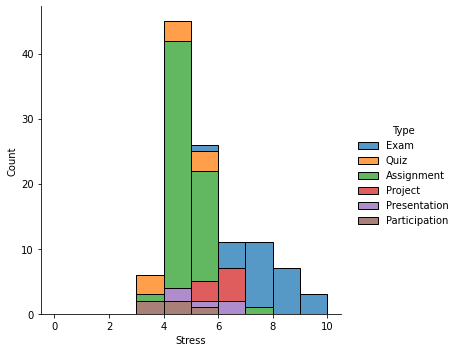

In [19]:
sns.displot(indiv_scores, x="Stress", bins=[0,1,2,3,4,5,6,7,8,9,10], hue='Type', multiple='stack')

In [20]:
indiv_scores[indiv_scores['Type']=='Exam'].sort_values(by=['Module Code', 'Semester'])

,Module Code,Semester,Name,Weightage,Type,Group or Individual,Start Date,Due Date,Level,Stress
2,DSA1101,2010,Finals,50.0,Exam,I,NaT,2020-11-30,level_1k,6.154235
1,DSA1101,2010,Midterm,40.0,Exam,I,NaT,NaT,level_1k,5.703616
11,DSA2101,2020,Finals,40.0,Exam,I,2021-04-26,2021-04-26,level_2k,7.175516
24,DSA2101,2110,Midterm,20.0,Exam,I,2021-10-10,2021-10-11,level_2k,6.325278
25,DSA2101,2110,Finals,40.0,Exam,I,2021-11-30,2021-11-30,level_2k,7.175516
31,DSA2102,2110,Midterm,25.0,Exam,I,2021-09-28,2021-09-28,level_2k,6.516183
32,DSA2102,2110,Finals,55.0,Exam,I,2021-12-02,2021-12-02,level_2k,7.834849
39,DSA2102,2120,Midterm,25.0,Exam,I,2022-02-28,2022-02-28,level_2k,6.516183
40,DSA2102,2120,Finals,55.0,Exam,I,2022-04-25,2022-04-25,level_2k,7.834849
53,DSA3102,2210,Midterm,20.0,Exam,I,2022-09-29,2022-09-29,level_3k,7.061228


# Pairwise Stress Score Calculations for Clashes

## For >= 2 clashes

In [21]:
def get_pairwise_stress(pair_cnt, class_size, clash_basescore):
    pairwise_stress = (pair_cnt/class_size) * clash_basescore
    
    return pairwise_stress

In [22]:
# returns all clash pairs on the specified date
def clash_pairs(df, date):
    data = []
    idx = list(df.index)
    assignment_combinations = list(combinations(idx, 2))
    
    # if no clashes
    if not assignment_combinations:
        return None
    else:
        for comb in assignment_combinations:
            assignment1 = comb[0]
            assignment2 = comb[1]
            scores = df.loc[df.index.isin([assignment1, assignment2]),'Stress'].tolist()
            modules = df.loc[df.index.isin([assignment1, assignment2]),'Module Code'].tolist()
            semester1 = df.loc[assignment1, "Semester"]
            semester2 = df.loc[assignment2, "Semester"]
            data.append({'Due Date': date, 'Semester': semester1, 'Module Code': modules, 'Assignment Index': [assignment1, assignment2], 'Stress': scores})

        df1 = pd.DataFrame(data)
        df1[['Module 1', 'Module 2']] = pd.DataFrame(df1['Module Code'].tolist(), index=df1.index)
        df1.drop('Module Code', axis=1, inplace=True)
    
        return df1

# Daily Stress Score Calculation

In [23]:
instructor_scores = indiv_scores.merge(instructors, how='left', on = ['Module Code', 'Semester'])
instructor_scores

,Module Code,Semester,Name,Weightage,Type,Group or Individual,Start Date,Due Date,Level,Stress,Instructor
0,DSA1101,2010,Finals,50.0,Exam,I,NaT,2020-11-30,level_1k,6.154235,Baoluo Sun
1,DSA2101,2020,Quiz 1,5.0,Quiz,I,2021-01-12,2021-01-19,level_2k,4.408517,s/o Gopal Vikneswaran
2,DSA2101,2020,Assignment 1,2.5,Assignment,I,2021-01-19,2021-01-26,level_2k,4.904978,s/o Gopal Vikneswaran
3,DSA2101,2020,Assignment 2,2.5,Assignment,I,2021-02-09,2021-02-16,level_2k,4.904978,s/o Gopal Vikneswaran
4,DSA2101,2020,Take-Home Midterms,30.0,Assignment,I,2021-03-02,2021-03-06,level_2k,5.804958,s/o Gopal Vikneswaran
...,...,...,...,...,...,...,...,...,...,...,...
113,ST4253,2210,Participation,10.0,Participation,I,NaT,NaT,level_4k,5.270971,Jialiang Li
114,ST4253,2210,Tutorial Presentation,10.0,Presentation,I,NaT,NaT,level_4k,6.006921,Jialiang Li
115,ST4248,2220,Presentation,10.0,Presentation,G,NaT,NaT,level_4k,6.190909,Ching Hway Lim
116,ST3247,2220,Tutorial Attendance,10.0,Participation,I,NaT,NaT,level_3k,4.535020,Ching Hway Lim


### Given an instructor name and date, get a df with a stress score for that day

In [24]:
# convert a date to its semester code
# to filter out assignments with incorrect due date (due date not in the semester)
def date_to_sem(date):
    year = date.year
    if date.month < 6:
        sem = str(year-1)[-2:] + '20'
    else:
        sem = str(year)[-2:] + '10'
    return int(sem)

In [25]:
# input = { instructor_scores : indiv_scores with additional instructor column,
#                 instructor :  the instructor logged in,
#                 date       :  date to calculate score for }
# output =  { daily_stress : stress score for that day, to be displayed to the given instructor }
def daily_stress_score(instructor_scores, instructor, date):
    # Filter by date
    df = instructor_scores[instructor_scores['Due Date'] == date]
    df = df.drop_duplicates(subset=df.columns.difference(['Instructor']))
    
    # Check that semester is correct
    sem = date_to_sem(date)
    df = df[df['Semester'] == sem]
    
    # if no assignments on that day
    if df.empty:
        return 0
    
    # if there are assignments on that day
    else:
        # check for clashes
        if clash_pairs(df, date) is None:
            return df['Stress'].tolist()[0]

        # if clashes
        else:
            # Get all clash pairs
            df1 = clash_pairs(df, date)

            # Filter clash pairs by instructor to get assignments affected for the instructor
            module_list = list(instructor_scores[instructor_scores['Instructor'] == instructor]['Module Code'].unique())
            df1 = df1[(df1['Module 1'].isin(module_list)) | (df1['Module 2'].isin(module_list))]
            

            # Get pairwise scores
            df1 = df1.merge(pair_counts, how='left', on=['Semester', 'Module 1', 'Module 2'])

            df1 = pd.merge(df1, student_counts, left_on=['Semester', 'Module 1'], right_on=['Semester', 'Module Code'], how = 'left')

            df1 = pd.merge(df1, student_counts, left_on=['Semester', 'Module 2'], right_on=['Semester', 'Module Code'], how = 'left')


            df1.rename(columns={"Count_y":"Module 1 Count", "Count":"Module 2 Count", "Count_x":"Pair Count"}, inplace=True)
            df1.drop(["Level_x", "Level_y", "Module Code_x", "Module Code_y"], axis=1, inplace=True)

            daily_score = 0
            if df1.loc[0, "Module 1"] in module_list:
                daily_score = df1.loc[0,"Stress"][0]
            else:
                daily_score = df1.loc[0,"Stress"][1]
            for i in range(0, len(df1)):
                pair_cnt = df1.loc[i, "Pair Count"]
                if df1.loc[i, 'Module 1'] in module_list:
                    class_size = df1.loc[i, "Module 1 Count"]
                    clash_basescore = df1.loc[i, "Stress"][1]
                else:
                    class_size = df1.loc[i, "Module 2 Count"] 
                    clash_basescore = df1.loc[i, "Stress"][0]

                pairwise_score = get_pairwise_stress(pair_cnt, class_size, clash_basescore) 
                daily_score += pairwise_score
                
            return daily_score

In [26]:
daily_stress_score(instructor_scores, 'Ching Hway Lim', pd.to_datetime('2023-04-07'))

5.454958223933232

In [27]:
daily_stress_score(instructor_scores, "Alexandre Hoang Thiery", pd.to_datetime("2023-04-07"))

5.454958223933232

## Stress score for a range of days (for deciding threshold)

In [28]:
def date_range(start_date, end_date):

    days = []
    current_date = start_date

    while current_date <= end_date:
        days.append(current_date)
        current_date += timedelta(days=1)
    
    return days

In [29]:
def multiple_days(instructor_scores, instructor, start_date, end_date):
    days = date_range(start_date, end_date)
    
    data = []
    for d in days:
        date = d
        daily_score = daily_stress_score(instructor_scores, instructor, d)
        data.append({'Date': date, 'Daily Stress Score': daily_score})
    
    daily_scores_df = pd.DataFrame(data)
    return daily_scores_df

In [30]:
multiple_days(instructor_scores, 'Ching Hway Lim', pd.to_datetime('2023-01-01'), pd.to_datetime('2023-05-31')).describe()

,Daily Stress Score
count,151.000000
mean,0.687492
std,2.142632
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,14.286249


## Deadline Extension Optimization (for the next 7 days)

### Helper functions

In [31]:
def seven_day_range(date):

    days = []
    current_date = date

    for i in range(0,7):
        days.append(current_date)
        current_date += timedelta(days=1)
    
    return days

In [32]:
seven_day_range(pd.to_datetime('2023-04-10'))

[Timestamp('2023-04-10 00:00:00'),
 Timestamp('2023-04-11 00:00:00'),
 Timestamp('2023-04-12 00:00:00'),
 Timestamp('2023-04-13 00:00:00'),
 Timestamp('2023-04-14 00:00:00'),
 Timestamp('2023-04-15 00:00:00'),
 Timestamp('2023-04-16 00:00:00')]

In [33]:
# assignment input is [module code, semester, name, weightage, type, group or individual, start date, due date, level]

def daily_stress_score_modified(instructor_scores, instructor, date, assignment):
    module_code = assignment[0]
    semester = assignment[1]
    name = assignment[2]
    weightage = assignment[3]
    assignment_type = assignment[4]
    i_or_g = assignment[5]
    start_date = assignment[6]
    due_date = date
    level = assignment[8]
    stress = indiv_score(weightage, assignment_type, i_or_g, level, start_date, due_date)
    
    # Filter by date
    df = instructor_scores[instructor_scores['Due Date'] == date]
    df = df.drop_duplicates(subset=df.columns.difference(['Instructor']))
    row = {'Module Code':module_code, 'Semester':semester, 'Name': name, 'Weightage':weightage, 'Type':assignment_type, 'Group or Individual': i_or_g, 'Start Date':start_date, 'Due Date':due_date, 'Level':level, 'Stress':stress, "Instructor":instructor}
    df = df.append(row, ignore_index=True)
    
    # Check that semester is correct
    sem = date_to_sem(date)
    df = df[df['Semester'] == sem]
    
    # if no assignments on that day
    if df.empty:
        return 0
    
    # if there are assignments on that day
    else:
        # check for clashes
        if clash_pairs(df, date) is None:
            return df['Stress'].tolist()[0]

        # if clashes
        else:
            # Get all clash pairs
            df1 = clash_pairs(df, date)

            # Filter clash pairs by instructor to get assignments affected for the instructor
            module_list = list(instructor_scores[instructor_scores['Instructor'] == instructor]['Module Code'].unique())
            df1 = df1[(df1['Module 1'].isin(module_list)) | (df1['Module 2'].isin(module_list))]
            

            # Get pairwise scores
            df1 = df1.merge(pair_counts, how='left', on=['Semester', 'Module 1', 'Module 2'])

            df1 = pd.merge(df1, student_counts, left_on=['Semester', 'Module 1'], right_on=['Semester', 'Module Code'], how = 'left')

            df1 = pd.merge(df1, student_counts, left_on=['Semester', 'Module 2'], right_on=['Semester', 'Module Code'], how = 'left')


            df1.rename(columns={"Count_y":"Module 1 Count", "Count":"Module 2 Count", "Count_x":"Pair Count"}, inplace=True)
            df1.drop(["Level_x", "Level_y", "Module Code_x", "Module Code_y"], axis=1, inplace=True)

            daily_score = 0
            #if df1.loc[0, "Module 1"] in module_list:
                #daily_score = df1.loc[0,"Stress"][0]
            #else:
                #daily_score = df1.loc[0,"Stress"][1]
            for i in range(0, len(df1)):
                pair_cnt = df1.loc[i, "Pair Count"]
                if df1.loc[i, 'Module 1'] in module_list:
                    class_size = df1.loc[i, "Module 1 Count"]
                    clash_basescore = df1.loc[i, "Stress"][1]
                else:
                    class_size = df1.loc[i, "Module 2 Count"] 
                    clash_basescore = df1.loc[i, "Stress"][0]

                pairwise_score = get_pairwise_stress(pair_cnt, class_size, clash_basescore) 
                daily_score += pairwise_score
                
            return daily_score

### Next 7 Days Function

In [34]:
def next_7_days(instructor_scores, instructor, assignment):
    due_date = assignment[7]
    days = seven_day_range(due_date)
    
    data = []
    for d in days:
        date = d
        daily_score = daily_stress_score_modified(instructor_scores, instructor, date, assignment)
        data.append({'Date':date,'Daily Stress Score':daily_score})
        
    daily_scores_df = pd.DataFrame(data)
    return daily_scores_df

In [35]:
assignment_eg = ["ST4248", 2220, "Final Report", 20, "Project", "G", None, pd.to_datetime("2023-04-10"), "level_4k"]

In [36]:
next_7_days(instructor_scores, "Alexandre Hoang Thiery", assignment_eg)

C:\Users\CHENSI~1\AppData\Local\Temp/ipykernel_24732/1763141066.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)
C:\Users\CHENSI~1\AppData\Local\Temp/ipykernel_24732/1763141066.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)
C:\Users\CHENSI~1\AppData\Local\Temp/ipykernel_24732/1763141066.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)
C:\Users\CHENSI~1\AppData\Local\Temp/ipykernel_24732/1763141066.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)
C:\Users\CHENSI~1\Ap

,Date,Daily Stress Score
0,2023-04-10,0.000000
1,2023-04-11,6.877241
2,2023-04-12,6.877241
3,2023-04-13,6.877241
4,2023-04-14,7.272801
5,2023-04-15,6.877241
6,2023-04-16,6.877241
